In [78]:
from utils.data_gatherer import *
import matplotlib.pyplot as plt
import numpy as np
import unicodedata
import matplotlib.pyplot as plt
import datetime
import jdatetime
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

1. Get daily data

In [79]:
symbol = 'اهرم'
price_df  = get_daily_price_data(symbol= symbol, start_date='1401-01-01', end_date='1403-12-29').set_index('Date')

In [80]:
price_df.head()

,jdate,High,Low,Final,Close,Open,Y-Final,Value,Volume,No,Weekday,Adj Open,Adj High,Adj Low,Adj Close,Adj Final
Date,,,,,,,,,,,,,,,,
2022-03-26,1401-01-06,10590,10300,10410,10490,10370,10250,-2147483648,1772010,121,Saturday,10370,10590,10300,10490,10410
2022-03-27,1401-01-07,10800,10410,10640,10740,10500,10410,-2147483648,6170979,314,Sunday,10500,10800,10410,10740,10640
2022-03-28,1401-01-08,11120,10650,10930,11000,10850,10640,-2147483648,10415710,416,Monday,10850,11120,10650,11000,10930
2022-03-29,1401-01-09,11100,10830,10900,10850,11020,10930,-2147483648,1831866,237,Tuesday,11020,11100,10830,10850,10900
2022-03-30,1401-01-10,11200,10700,10750,10990,11200,10900,-2147483648,13065424,477,Wednesday,11200,11200,10700,10990,10750


2. MontCarlo Simulation

In [81]:
yearly_days = 252
path_num = 10000
steps_num = 120
dt = 1/252

past_price = price_df['Adj Close'].iloc[:-steps_num]
foward_price = price_df['Adj Close'].iloc[-steps_num:]

return_series = np.diff(np.log(past_price))
mu = np.mean(return_series) * yearly_days
sigma = np.std(return_series) * yearly_days ** (0.5)

random_array = np.random.randn(path_num, steps_num)
simulated_price_array = np.zeros((path_num, steps_num))

In [82]:
simulated_price_array[:, 0] = past_price.iloc[-1]
for i in range(steps_num-1):
    random_array[:, i] = (random_array[:, i] - np.mean(random_array[:, i])) / np.std(random_array[:, i])
    simulated_price_array[:, i+1] = simulated_price_array[:, i] * np.exp(((mu-sigma**2/2)) * dt + sigma * np.sqrt(dt) * random_array[:, i])

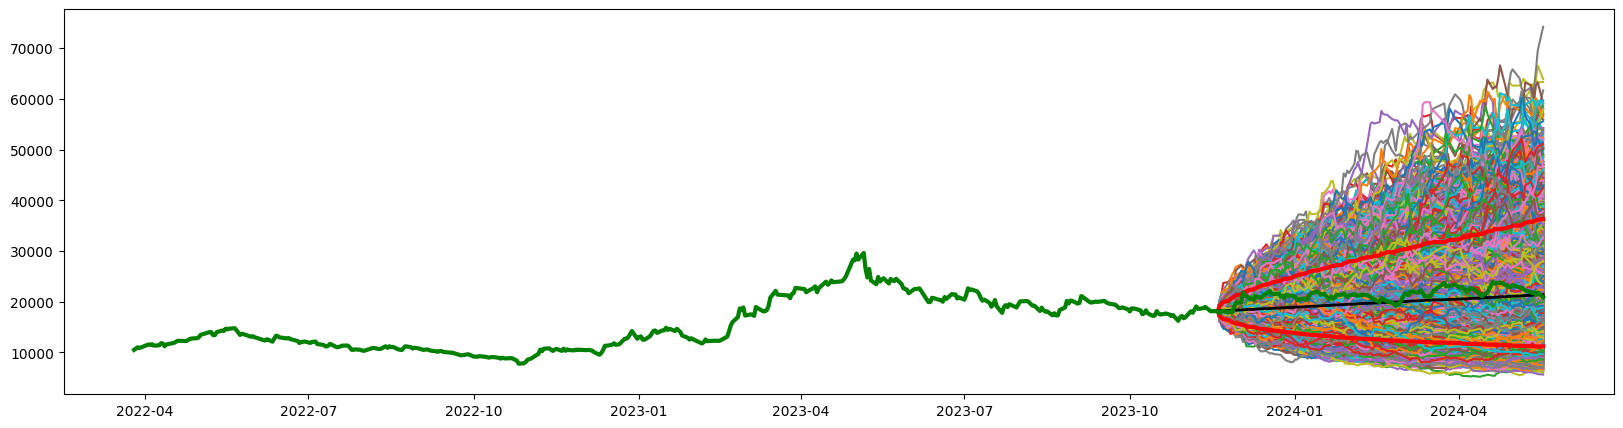

In [83]:
lower_bound, upper_bound = np.quantile(simulated_price_array, 0.05, axis=0).reshape(-1, 1), np.quantile(simulated_price_array, 0.95, axis=0).reshape(-1, 1)
lower_bound, upper_bound = lower_bound.reshape(-1, 1), upper_bound.reshape(-1, 1)

plt.figure(figsize=(20, 5))
plt.plot(foward_price.index, simulated_price_array.T)
plt.plot(foward_price.index, np.hstack((lower_bound, upper_bound)), linewidth=3, color='red')
plt.plot(foward_price.index, np.mean(simulated_price_array, axis=0), linewidth=2, color='black')
plt.plot(price_df['Adj Close'], linewidth=3, color='green')
plt.show()

- VAR

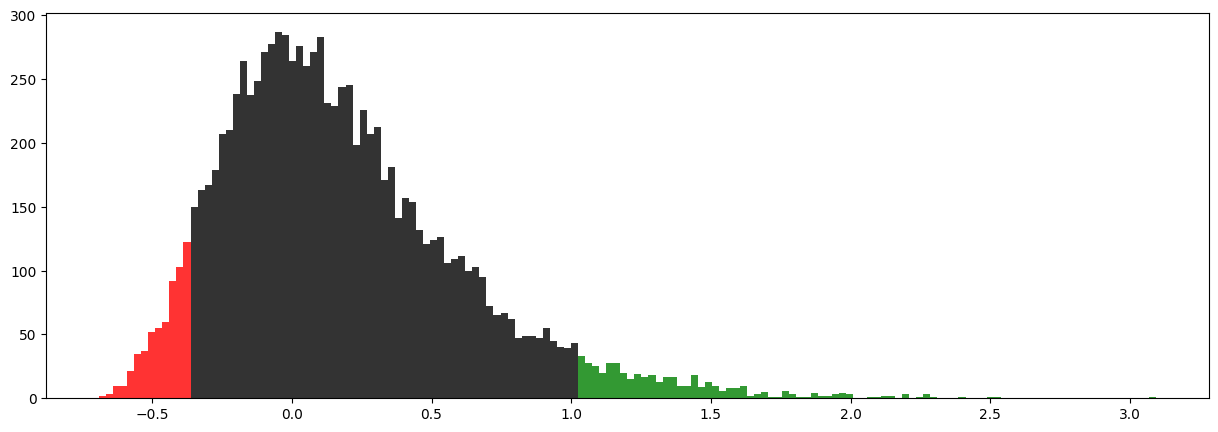

In [86]:
due_all_price = simulated_price_array[:, -1]
due_all_return = (due_all_price/past_price[-1]) - 1

plt.figure(figsize=(15, 5))
counts, bin_edges, patches = plt.hist(due_all_return, bins=150, color='black', alpha=0.8)
for patch, edge in zip(patches, bin_edges):
    if edge >= np.quantile(due_all_return, 0.95):
        patch.set_facecolor('green')
    elif edge <= np.quantile(due_all_return, 0.05):
        patch.set_facecolor('red')

plt.show()

In [91]:
var = np.quantile(due_all_return, 0.05)
print(f'The Monte Carlo simulation, therefore, leads to the following VaR-type conclusion: with 95% confidence,\n \
      we do not expect to lose more than {-var: .1%} during future {steps_num} days.')

The Monte Carlo simulation, therefore, leads to the following VaR-type conclusion: with 95% confidence,
       we do not expect to lose more than  38.2% during future 120 days.


3. option pricing

  ![Sample Image](utils/images/option_example.png)

- option parameters

In [92]:
due_date = jdatetime.date(1403,4,27).togregorian()
today_date = datetime.date.today()
dtm = (due_date - today_date).days #days to maturity
strike_price = 20000
today_asset_price = price_df['Adj Close'].iloc[-1]

* montcarlo


In [93]:
yearly_days = 252
path_num = 10000
steps_num = dtm
dt = 1/252

past_price = price_df['Adj Close']
foward_price = price_df['Adj Close'].iloc[-steps_num:]
foward_price = [0] * len(foward_price)

return_series = np.diff(np.log(past_price))
mu = np.mean(return_series) * yearly_days
sigma = np.std(return_series) * yearly_days ** (0.5)

random_array = np.random.randn(path_num, steps_num)
simulated_price_array = np.zeros((path_num, steps_num))


simulated_price_array[:, 0] = past_price.iloc[-1]
for i in range(steps_num-1):
    random_array[:, i] = (random_array[:, i] - np.mean(random_array[:, i])) / np.std(random_array[:, i])
    simulated_price_array[:, i+1] = simulated_price_array[:, i] * np.exp(((mu-sigma**2/2)) * dt + sigma * np.sqrt(dt) * random_array[:, i])

In [94]:
due_date_payoff = max(simulated_price_array[:, -1].mean() - strike_price, 0)
call_price = due_date_payoff * (np.e ** (-mu*dtm/252))
call_price.round(0)

2378.0

* black-scholes

In [95]:
def blackScholes(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    try:
        if type == "c":
            price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif type == "p":
            price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)

        return price
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

In [98]:
blackScholes(mu, today_asset_price, strike_price, dtm/365,sigma).round(0)

2730.0